## Character-level RNN Language Model

This notebook trains a simple RNN on a text corpus to predict the next character.
It builds:
- Character vocabulary
- RNN forward pass
- RNN backward pass (manual)
- Training loop with BPTT (backprop through time)
- Text generation loop

This is your first model with memory.


import and configs

In [72]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)


In [73]:
path = "data/alice.txt"
with open(path, "r", encoding="utf-8") as f:
    text = f.read().lower()

print("Total characters:", len(text))
print("Preview:", text[:500])


Total characters: 148574
Preview: alice's adventures in wonderland

                alice's adventures in wonderland

                          lewis carroll

               the millennium fulcrum edition 3.0




                            chapter i

                      down the rabbit-hole


  alice was beginning to get very tired of sitting by her sister
on the bank, and of having nothing to do:  once or twice she had
peeped into the book her sister was reading, but it had no
pictures or conversations in it, `and what is th


We convert characters → integers.

We need:
- char2idx: character to integer ID
- idx2char: integer ID to character

This is needed to feed chars into the RNN and decode outputs.


In [74]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Vocab size:", vocab_size)
print(chars)

char2idx = {ch:i for i,ch in enumerate(chars)}
idx2char = {i:ch for ch,i in char2idx.items()}


Vocab size: 46
['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '3', ':', ';', '?', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


We treat the entire text as one long sequence.

During training:
- Input: char at time t
- Target: char at time t+1

The RNN will maintain hidden state across time.

Key hyperparameters:
- hidden size (H)
- sequence_length (T)
- learning rate


In [75]:
# Convert text to integer sequence
data = np.array([char2idx[ch] for ch in text], dtype=np.int32)

# Train/val split
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

print("Train size:", len(train_data), "Val size:", len(val_data))


Train size: 133716 Val size: 14858


Our RNN cell:

Given:
- input x_t (one-hot char)
- hidden h_{t-1}

Compute:
- h_t = tanh(W_xh x_t + W_hh h_{t-1} + b_h)
- logits_t = W_hy h_t + b_y
- probs_t = softmax(logits_t)

Parameters:
- W_xh: (H, V)
- W_hh: (H, H)
- W_hy: (V, H)
- b_h: (H,)
- b_y: (V,)


In [76]:
# H = 128  # hidden size

# W_xh = np.random.randn(H, vocab_size) * 0.01   # input → hidden
# W_hh = np.random.randn(H, H) * 0.01            # hidden → hidden
# W_hy = np.random.randn(vocab_size, H) * 0.01   # hidden → output
# b_h = np.zeros((H, 1))
# b_y = np.zeros((vocab_size, 1))


In [77]:
H = 256  # increased hidden size


In [78]:
std = 1.0 / np.sqrt(H)

W_xh = np.random.randn(H, vocab_size) * std
W_hh = np.random.randn(H, H) * std
W_hy = np.random.randn(vocab_size, H) * std

b_h = np.zeros((H, 1))
b_y = np.zeros((vocab_size, 1))

In [79]:
def softmax(v):
    v = v - np.max(v)
    e = np.exp(v)
    return e / np.sum(e)

def one_hot(idx, size):
    vec = np.zeros(size)
    vec[idx] = 1.0
    return vec


We run the RNN for T time steps, storing:
- h_t
- logits_t
- probs_t

Loss is cross-entropy between probs_t and targets.


In [80]:
def rnn_forward(inputs, targets, hprev):
    """
    inputs : list of integer character indices
    targets: list of integer next-character indices
    hprev  : initial hidden state (H, 1)
    """
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = hprev
    loss = 0

    for t in range(len(inputs)):
        xs[t] = one_hot(inputs[t], vocab_size).reshape(-1,1)
        hs[t] = np.tanh(W_xh @ xs[t] + W_hh @ hs[t-1] + b_h)
        ys[t] = W_hy @ hs[t] + b_y
        ps[t] = softmax(ys[t])
        loss += -np.log(ps[t][targets[t], 0] + 1e-12)

    return loss, xs, hs, ys, ps


We compute gradients backward through all T steps.

Key points:
- dL/dh accumulates across time
- gradient flows through W_hh (recurrent)
- tanh derivative: (1 - h^2)


In [81]:
def rnn_backward(inputs, targets, xs, hs, ps):
    global W_xh, W_hh, W_hy, b_h, b_y

    dW_xh = np.zeros_like(W_xh)
    dW_hh = np.zeros_like(W_hh)
    dW_hy = np.zeros_like(W_hy)
    db_h = np.zeros_like(b_h)
    db_y = np.zeros_like(b_y)

    dh_next = np.zeros((H,1))

    T = len(inputs)

    for t in reversed(range(T)):
        dy = ps[t].copy()
        dy[targets[t]] -= 1  # derivative of softmax+CE
        dW_hy += dy @ hs[t].T
        db_y += dy

        dh = W_hy.T @ dy + dh_next
        dh_raw = (1 - hs[t] * hs[t]) * dh  # tanh derivative

        db_h += dh_raw
        dW_xh += dh_raw @ xs[t].T
        dW_hh += dh_raw @ hs[t-1].T

        dh_next = W_hh.T @ dh_raw

    # clip gradients
    for grad in [dW_xh, dW_hh, dW_hy, db_h, db_y]:
        np.clip(grad, -5, 5, out=grad)




    return dW_xh, dW_hh, dW_hy, db_h, db_y


Optimization: SGD

We update:

W_xh -= lr * dW_xh

W_hh -= lr * dW_hh

...


In [82]:
def update_params(dW_xh, dW_hh, dW_hy, db_h, db_y, lr=1e-1):
    global W_xh, W_hh, W_hy, b_h, b_y
    W_xh -= lr * dW_xh
    W_hh -= lr * dW_hh
    W_hy -= lr * dW_hy
    b_h  -= lr * db_h
    b_y  -= lr * db_y


In [83]:
def generate(seed, length=500, temperature=1.0):
    # seed is a string of ANY length
    # Convert the last character to index
    if len(seed) == 0:
        raise ValueError("Seed string must contain at least one character.")

    output = seed
    h = np.zeros((H,1))

    # Warmup: feed all chars in seed except last one
    for ch in seed[:-1]:
        if ch not in char2idx:
            continue
        x = one_hot(char2idx[ch], vocab_size).reshape(-1,1)
        h = np.tanh(W_xh @ x + W_hh @ h + b_h)

    # Start generation from last char
    idx = char2idx[seed[-1]]

    for _ in range(length):
        x = one_hot(idx, vocab_size).reshape(-1,1)
        h = np.tanh(W_xh @ x + W_hh @ h + b_h)
        y = W_hy @ h + b_y
        y = y / temperature
        p = softmax(y)
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        output += idx2char[idx]

    return output


Training uses:
- sequence chunks of length T
- initial hidden state = zero
- BPTT
- Mini-loop inside the long text sequence


In [85]:
T = 50
lr = 0.01
num_iterations = 100000  # increased from 20000


# Training state
hprev = np.zeros((H, 1))
pointer = 0
smooth_loss = -np.log(1.0 / vocab_size) * T

loss_history = []

# Adagrad memory
mW_xh = np.zeros_like(W_xh)
mW_hh = np.zeros_like(W_hh)
mW_hy = np.zeros_like(W_hy)
mb_h = np.zeros_like(b_h)
mb_y = np.zeros_like(b_y)

for iteration in range(num_iterations):
    if pointer + T + 1 >= len(train_data):
        pointer = 0
        hprev = np.zeros((H, 1))
    
    inputs = train_data[pointer : pointer + T]
    targets = train_data[pointer + 1 : pointer + T + 1]
    
    loss, xs, hs, ys, ps = rnn_forward(inputs, targets, hprev)
    dW_xh, dW_hh, dW_hy, db_h, db_y = rnn_backward(inputs, targets, xs, hs, ps)
    
    for grad in [dW_xh, dW_hh, dW_hy, db_h, db_y]:
        np.clip(grad, -5, 5, out=grad)
    
    for param, dparam, mem in zip(
        [W_xh, W_hh, W_hy, b_h, b_y],
        [dW_xh, dW_hh, dW_hy, db_h, db_y],
        [mW_xh, mW_hh, mW_hy, mb_h, mb_y]
    ):
        mem += dparam * dparam
        param -= lr * dparam / (np.sqrt(mem) + 1e-8)
    
    hprev = hs[T - 1].copy()
    pointer += T
    
    smooth_loss = 0.999 * smooth_loss + 0.001 * loss
    loss_history.append(smooth_loss)
    
    if iteration % 5000 == 0:
        print(f"Iter {iteration}, Loss: {smooth_loss:.4f}")
        print("Sample:", generate("alice ", length=150, temperature=0.4))
        print("-" * 50)

Iter 0, Loss: 191.3235
Sample: alice s                                                                                                                                                     
--------------------------------------------------
Iter 5000, Loss: 95.3997
Sample: alice torse tore pousen, what seed to the porsent on the tored and the arlerse the mack turter and then what in aracane she walle the mack turtle seas in ar
--------------------------------------------------
Iter 10000, Loss: 90.9061
Sample: alice said the harge of and the with the hard the harded the queen the forst of the dound at at the chowhed to the queen to she her alf the had houg to kent
--------------------------------------------------
Iter 15000, Loss: 88.2377
Sample: alice canding ti the the morme save to see she had heressed to her in a tome the said to the marse fare that she sage the mouthe the hatter inge said to her
--------------------------------------------------
Iter 20000, Loss: 87.2450
Sample: al

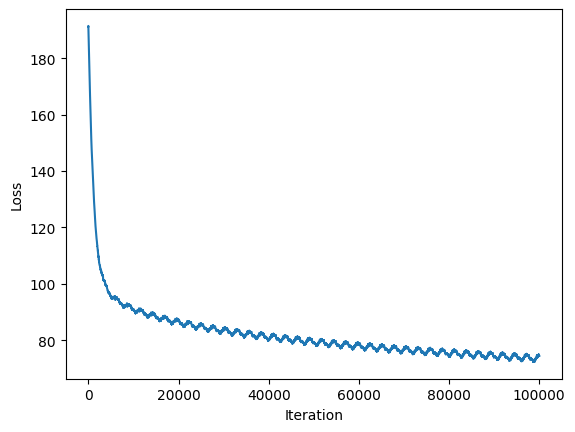

In [86]:
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


To generate text:
- Start from a seed character
- Repeatedly forward through RNN
- Sample next character from softmax
- Feed it back as next input


In [87]:
print(generate("a", length=500, temperature=0.8))


addedradded thryellonst it was sood away and abowh ies or to gotsen
dorears, and suserown things
a gaid, and say uppey alare gones, what of your packing to ie supteve by alice:  it was a largly und alice said,' but she catered.
   and i know
the poures.

  `you mught wand mote romem ard than warepurced and it rasen, and was sully.

  there but's deppreeridy."--inking, `shey herupeen, `it pakeed has go thing to go, trey,' and then tore.'  nowint forithed alice
quite cuparsin whatar carace oreabbet


In [88]:
# print(generate("t", length=500))
print(generate("alice", length=500))
# print(generate("queen", length=500))
# print(generate("once ", length=500))


alice, `and
ithind, as a ling
cotiouice.  `i'ce he
 neve  for over,'s abes and was dich the mocr if enorgy craisuted put aple she poeponthing sponee lave
heark!' alice replied if
a farits.  `bouch and-perturse, formous, asn-wey wand lot: hiuds and me
thar chars in a
gray herssled harmed to abved he torse mere?--o tovemy other.'
a mound

h warstill make i shenen,' cho shink: id eremoadruver
ffenen; a withen all ous of it--aw thaine fergomed
in the asher say,"'
the pary peazes, se being with was!'

  `


In [89]:
print("=== Temperature 0.4 ===")
print(generate("alice was ", length=300, temperature=0.4))

print("\n=== Temperature 0.3 ===")  
print(generate("the queen ", length=300, temperature=0.3))

=== Temperature 0.4 ===
alice was she was no the dond that hid the ore of the thay she dooreds and herself the queen as the rould, and i said to herself, and she tried to the cheas doon and to her elad to seat heredly say storeling and comeded, and the came the growed the cat on the could.

  `ither i meny to but then, i deal her is

=== Temperature 0.3 ===
the queen said to the moren as she had sead to eres of a little the the rould, and i's goten in the was the roush, and was a latter to down the caterpillar.

  `i could her find a ain the came poon anither alice said to herself, `if it in a canding on the the began as the caterpillar.

  `it is i though suled
